In [2]:
!bash <(curl -sL https://gitlab.aicrowd.com/jyotish/food-recognition-challenge-detectron2-baseline/raw/master/utils/setup-colab.sh)

AIcrowd installer starting...
Setting up the environment for you!
⚙️ Installing PyTorch...
⚙️ Installing COCO API...
  Running command git clone --filter=blob:none -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-op77eikn
⚙️ Installing detectron...
🗄 Preparing the dataset for training...
[train-v0.4.tar.gz]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train-v0.4.tar.gz or
        train-v0.4.tar.gz.zip, and cannot find train-v0.4.tar.gz.ZIP, period.
🗄 Preparing the validation dataset...
[val-v0.4.tar.gz]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found o

In [1]:
class Paths:
  DATASET_DIR = "/home/wenjinyuan/project/food_data"
  TRAIN_DATA_DIR = "/home/wenjinyuan/project/food_data/train"
  TRAIN_IMAGES_DIR = "/home/wenjinyuan/project/food_data/train/images"
  TRAIN_ANNOTATIONS = "/home/wenjinyuan/project/food_data/train/annotations.json"

  VAL_DATA_DIR = "/home/wenjinyuan/project/food_data/val"
  VAL_ANNOTATIONS = "/home/wenjinyuan/project/food_data/val/annotations.json"
  VAL_IMAGES_DIR = "/home/wenjinyuan/project/food_data/val/images"


class DatasetLabels:
  TRAIN = "dataset_train"
  VAL = "dataset_val"

In [2]:
import os
from multiprocessing import Pool
import json

from tqdm.notebook import tqdm
from pycocotools.coco import COCO
import numpy as np
import cv2

from detectron2.data.datasets import register_coco_instances
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.events import get_event_storage
from detectron2.engine import HookBase

In [3]:
with open(Paths.TRAIN_ANNOTATIONS) as fp:
  annotations = json.load(fp)

In [4]:
image_dir = ""


def validate_annotation(annotation):
  """Check the image dimensions and fix them if needed
  """
  filepath = os.path.join(image_dir, annotation.get("file_name"))
  if not os.path.exists(filepath):
    print("Skipping", filepath)
    return annotation
  img = cv2.imread(filepath)
  if img.shape[0] != annotation.get("height") or img.shape[1] != annotation.get("width"):
    annotation["height"], annotation["width"] = annotation["width"], annotation["height"]
  return annotation


def clean_annotations(annotation_images):
  """Read the image dimensions and fix them in parallel
  """
  annotated_images = []

  with Pool() as p:
    total_images = len(annotation_images)

    with tqdm(total=total_images) as progress_bar:
      for annotation in p.imap(validate_annotation, annotation_images):
        annotated_images.append(annotation)
        progress_bar.update(1)

  return annotated_images

In [5]:
image_dir = Paths.TRAIN_IMAGES_DIR
annotations["images"] = clean_annotations(annotations.get("images"))

with open(Paths.TRAIN_ANNOTATIONS, "w") as fp:
  json.dump(annotations, fp)

  0%|          | 0/24119 [00:00<?, ?it/s]

In [6]:
image_dir = Paths.VAL_IMAGES_DIR

with open(Paths.VAL_ANNOTATIONS) as fp:
  validation_annotations = json.load(fp)

validation_annotations["images"] = clean_annotations(validation_annotations.get("images"))

with open(Paths.VAL_ANNOTATIONS, "w") as fp:
  json.dump(validation_annotations, fp)

  0%|          | 0/1269 [00:00<?, ?it/s]

In [7]:
_ = setup_logger()

register_coco_instances(DatasetLabels.TRAIN, {}, Paths.TRAIN_ANNOTATIONS, Paths.TRAIN_IMAGES_DIR)
register_coco_instances(DatasetLabels.VAL, {}, Paths.VAL_ANNOTATIONS, Paths.VAL_IMAGES_DIR)

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = (DatasetLabels.TRAIN,)
cfg.DATASETS.TEST = (DatasetLabels.VAL,)
cfg.TEST.EVAL_PERIOD = 400
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 273  # Number of output classes

cfg.OUTPUT_DIR = "outputs"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [9]:
from train_eval.LossEvalHook import LossEvalHook

In [10]:
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2

In [11]:
cfg.SOLVER.BASE_LR = 0.00025  # Learning Rate
cfg.SOLVER.MAX_ITER = 20000
#20000  # MAx Iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # Batch Size

In [12]:
%reload_ext tensorboard
%tensorboard --logdir outputs

In [13]:
from train_eval.MyTrainer import MyTrainer
from detectron2.data import build_detection_test_loader

In [14]:
#trainer = DefaultTrainer(cfg)

trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[10/22 20:09:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Using TensorFlow backend.


[10/22 20:09:16 d2.data.common]: Serialized dataset takes 3.62 MiB


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (274, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (274,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (1092, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (1092,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (273, 2

[10/22 20:09:18 d2.engine.train_loop]: Starting training from iteration 0
[10/22 20:09:39 d2.utils.events]:  eta: 5:34:17  iter: 19  total_loss: 7.092  loss_cls: 5.740  loss_box_reg: 0.601  loss_mask: 0.692  loss_rpn_cls: 0.014  loss_rpn_loc: 0.017  time: 0.9978  data_time: 0.0339  lr: 0.000005  max_mem: 1926M
[10/22 20:09:59 d2.utils.events]:  eta: 5:35:10  iter: 39  total_loss: 6.859  loss_cls: 5.604  loss_box_reg: 0.560  loss_mask: 0.693  loss_rpn_cls: 0.018  loss_rpn_loc: 0.015  time: 1.0037  data_time: 0.0053  lr: 0.000010  max_mem: 1926M
[10/22 20:10:19 d2.utils.events]:  eta: 5:37:21  iter: 59  total_loss: 6.532  loss_cls: 5.201  loss_box_reg: 0.552  loss_mask: 0.694  loss_rpn_cls: 0.018  loss_rpn_loc: 0.017  time: 1.0025  data_time: 0.0051  lr: 0.000015  max_mem: 1926M
[10/22 20:10:40 d2.utils.events]:  eta: 5:40:33  iter: 79  total_loss: 6.006  loss_cls: 4.563  loss_box_reg: 0.633  loss_mask: 0.692  loss_rpn_cls: 0.017  loss_rpn_loc: 0.016  time: 1.0085  data_time: 0.0058  lr:

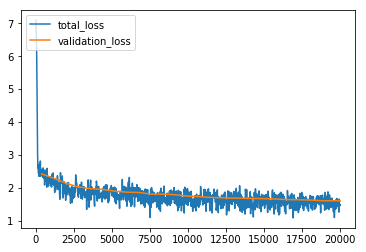

In [15]:
import json
import matplotlib.pyplot as plt

#experiment_folder = './output/model_iter4000_lr0005_wf1_date2020_03_20__05_16_45'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr('/home/wenjinyuan/project/outputs/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics], 
    [x['total_loss'] for x in experiment_metrics])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.show()

In [16]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = (DatasetLabels.VAL, )
predictor = DefaultPredictor(cfg)

In [41]:
#evaluator1=sem_seg_evaluation.SemSegEvaluator(DatasetLabels.VAL, distributed=False,output_dir=cfg.OUTPUT_DIR,num_classes=cfg.MODEL.ROI_HEADS.NUM_CLASSES)

#detectron2.evaluation.SemSegEvaluator(dataset_name, distributed=True, output_dir=None, *, num_classes=None, ignore_label=None)

In [17]:
evaluator = COCOEvaluator(DatasetLabels.VAL, cfg, False, output_dir=cfg.OUTPUT_DIR)
data_loader = build_detection_test_loader(cfg, DatasetLabels.VAL)
results = inference_on_dataset(predictor.model, data_loader, evaluator)

WARNING [10/23 12:20:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/23 12:20:50 d2.data.datasets.coco]: Loaded 1269 images in COCO format from /home/wenjinyuan/project/food_data/val/annotations.json
[10/23 12:20:50 d2.data.common]: Serializing 1269 elements to byte tensors and concatenating them all ...
[10/23 12:20:51 d2.data.common]: Serialized dataset takes 3.62 MiB
[10/23 12:20:51 d2.evaluation.evaluator]: Start inference on 1269 images
[10/23 12:20:54 d2.evaluation.evaluator]: Inference done 11/1269. 0.2838 s / img. ETA=0:05:58
[10/23 12:20:59 d2.evaluation.evaluator]: Inference done 29/1269. 0.2857 s / img. ETA=0:05:56
[10/23 12:21:04 d2.evaluation.evaluator]: Inference done 47/1269. 0.2852 s / img. ETA=0:05:50
[10/23 12:21:09 d2.evaluation.evaluator]: Inference done 65/1269. 0.2855 s / img. ETA=0:05:46
[10/23 12:21:15 d2.evaluation.evaluator]: Inference done 83/1269. 0.2849 s / img. ETA=0:05:40
[10/23 12:2

In [18]:
metadata = MetadataCatalog.get(DatasetLabels.VAL)

# Load the training annotations if not loaded
if not validation_annotations:
  with open(Paths.VAL_ANNOTATIONS) as json_file:
      annotations = json.load(json_file)

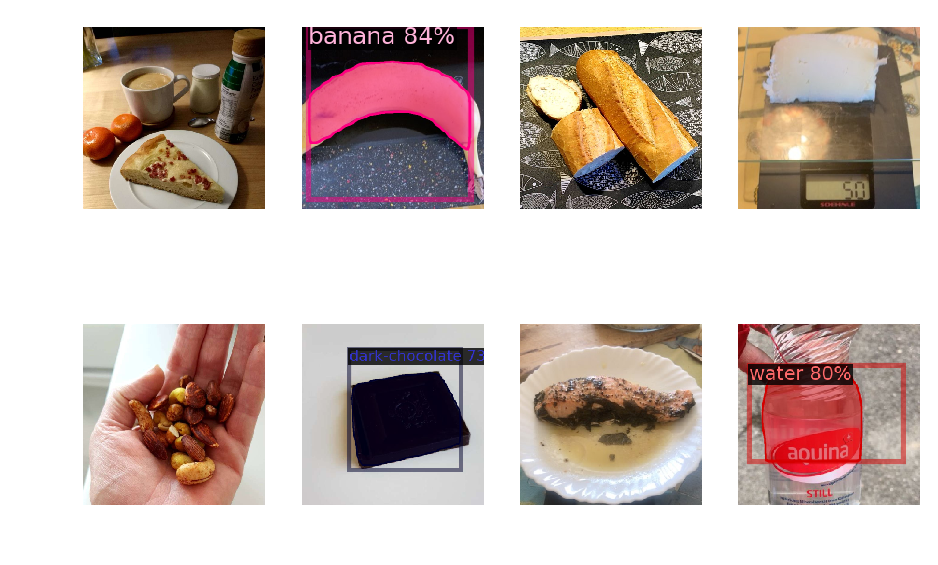

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 180


# Visualize some random images
for i in range(8):
  image_filename = np.random.choice(validation_annotations.get("images")).get("file_name")
  image_filename = os.path.join(Paths.VAL_IMAGES_DIR, image_filename)

  img = cv2.imread(image_filename)
  predictions = predictor(img)

  v = Visualizer(img[:, :, ::-1],
    metadata=metadata, 
    scale=0.5, 
    # instance_mode=ColorMode.IMAGE_BW
  )
  annotated_image = v.draw_instance_predictions(predictions["instances"].to("cpu"))

  plt.subplot(2, 4, i+1)
  plt.axis('off')
  plt.imshow(annotated_image.get_image())

In [37]:
from detectron2.evaluation import sem_seg_evaluation